## Python script to load subset of netCDF data into memory

> **Author**: Sunny Bak Hospital from PolarWatch  
> **Date Created**: 06.06.2024  
> **Email**: [sun.bak-hospital@noaa.gov](mailto:sun.bak-hospital@noaa.gov)

### Description

This notebook demonstrates the process of spatially subsetting and loading remote sensing data projected in polar stereographic coordinates from multiple files on a https server. 

__data source__ 
https://noaadata.apps.nsidc.org/NOAA/G02156/netcdf/1km/


In [5]:
# Load packages
import xarray as xr
import requests
from zipfile import ZipFile
from io import BytesIO
from bs4 import BeautifulSoup
import gzip

In [6]:

def list_files(url):
    """returns a list of full urls of data files listed on the server page 
    Args:
        url (str): url of the https server with the list of data file names

    Returns:
        _type_: list of file urls
    """
    response = requests.get(url)
    response.raise_for_status()  # error handling 
    soup = BeautifulSoup(response.text, 'html.parser')
    return [url + '/' + link.get('href') for link in soup.find_all('a') if link.get('href').endswith('.gz')]


In [7]:

def process_file(url):
    """function to download and subset a single gzip NetCDF file

    Args:
        url (str): Full https URL of a netCDF file
    """
    response = requests.get(url)
    response.raise_for_status()   

    
    # Unzip the content in memory
    with gzip.GzipFile(fileobj=BytesIO(response.content)) as gz:
        with BytesIO(gz.read()) as nc_file:
            ds = xr.open_dataset(nc_file)
            subds = ds.sel(x=slice(-3398000, -2998000), y=slice(-998000, -598000)).load()
            return subds




In [9]:

# 11m22.7s to process 2023 
base_url = 'https://noaadata.apps.nsidc.org/NOAA/G02156/netcdf/1km/'
years = [2023, 2023]
mfiles = []
list_subset = []

for year in range(years[0], years[1] + 1):
    year_url = f'{base_url}{year}'
    try:
        file_urls = list_files(year_url)
        for f in file_urls:
            try:
                ds = process_file(f)
                list_subset.append(ds)
            except Exception as e:
                print(f"Failed to process (unzip, subset) {f}: {e}")
    except Exception as e:
        print(f"Failed to get files from {year_url}: {e}")

if list_subset:
    total_ds = xr.concat(list_subset, dim='time')
else:
    total_ds = None
    print("No data to concatenate.")

In [10]:
# examine metadata
total_ds


<xarray.Dataset> Size: 234MB
Dimensions:             (time: 365, y: 400, x: 400)
Coordinates:
  * x                   (x) float32 2kB -3.398e+06 -3.396e+06 ... -2.998e+06
  * y                   (y) float32 2kB -9.975e+05 -9.965e+05 ... -5.985e+05
  * time                (time) datetime64[ns] 3kB 2023-01-01 ... 2023-12-31
Data variables:
    IMS_Surface_Values  (time, y, x) float32 234MB 1.0 1.0 4.0 ... 4.0 4.0 4.0
    projection          (time) |S1 365B b'' b'' b'' b'' b'' ... b'' b'' b'' b''
Attributes: (12/49)
    Conventions:                CF-1.6, ACDD-1.3
    title:                      NOAA/NESDIS Interactive Multisensor Snow and ...
    summary:                    This file contains a map of snow cover and ic...
    keywords:                   EARTH SCIENCE > CRYOSPHERE > SEA ICE > ICE EX...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Ke...
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    ...                         ...
    metadata_link:              https://nsidc.org/data/G02156
    naming_authority:           org.nsidc
    references:                 Ramsay, B. H. (1998). The interactive multise...
    history:                    01 January 2023 00:35Z: NetCDF file generated...
    source:                     Analysts at the United States National Ice Ce...
    comment:                    The IMS product has changed versions and reso...

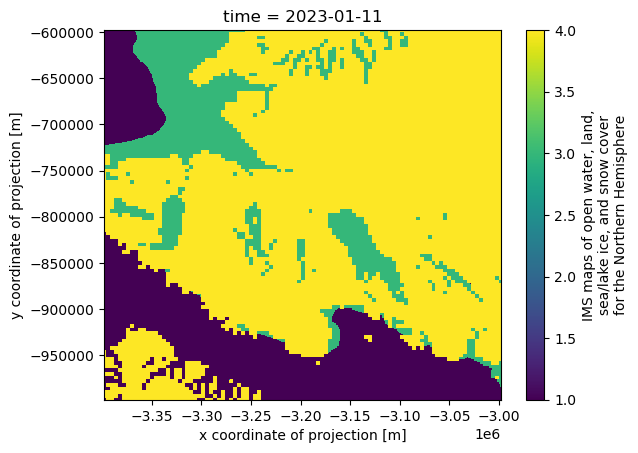

In [11]:
# Select one time step data at 10 and visualize
total_ds.isel(time=10)["IMS_Surface_Values"].plot()

In [12]:
total_ds.to_netcdf('ims1k_2023.nc')